### Stimulus decoding

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

In [2]:
import argparse
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from frites.dataset import DatasetEphy
from frites.estimator import GCMIEstimator
from frites.workflow import WfMi
from mne.time_frequency import psd_array_multitaper
from scipy.stats import mannwhitneyu
from tqdm import tqdm
from utils import *

from config import get_dates
from GDa.session import session
from GDa.temporal_network import temporal_network
from GDa.util import _extract_roi, average_stages

In [3]:
def remove_same_roi(df):

    rois = df.roi.values
    roi_s, roi_t = _extract_roi(rois, "-")
    return df.iloc[~(roi_s == roi_t), :]


def node_remove_sca(df):

    sca = ["Caudate", "Claustrum", "Thal", "Putamen"]
    idx = np.array([r in sca for r in df.roi.values])
    return df.iloc[~idx, :]


def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a, idx, axis=axis)


def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"


def add_stats_annot(pval, x1, x2, y, h, col="k"):
    plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
    plt.text(
        (x1 + x2) * 0.5,
        y + h,
        convert_pvalue_to_asterisks(pval),
        ha="center",
        va="bottom",
        color=col,
    )


def load_session_data(sid):

    # Instantiate class
    ses = session(
        raw_path=os.path.expanduser("~/funcog/gda/GrayLab/"),
        monkey="lucy",
        date=sid,
        session=1,
        slvr_msmod=False,
        align_to="cue",
        evt_dt=[-0.65, 1.50],
    )

    # Read data from .mat files
    ses.read_from_mat()

    # Filtering by trials
    data = ses.filter_trials(trial_type=[1], behavioral_response=[1])

    return data


def compute_pval(df_plot, stage, stim_label_1, stim_label_2):
    _, p = mannwhitneyu(
        df_plot.loc[
            (df_plot.times == stage) & (df_plot.trials == stim_label_1)
        ].power.values,
        df_plot.loc[
            (df_plot.times == stage) & (df_plot.trials == stim_label_2)
        ].power.values,
    )
    return p

In [19]:
avg = 1
tt = 1
br = 1
at = "cue"
monkey = "lucy"

In [20]:
_ROOT = os.path.expanduser("~/funcog/gda")

In [21]:
def load_session_power(s_id, z_score=False, avg=0, roi=None):
    _FILE_NAME = f"power_tt_{tt}_br_{br}_at_{at}.nc"
    path_pow = os.path.join(_ROOT, f"Results/lucy/{s_id}/session01", _FILE_NAME)
    power = xr.load_dataarray(path_pow)
    if z_score:
        power.values = (power - power.mean("times")) / power.std("times")
    # Averages power for each period (baseline, cue, delay, match) if needed
    out = average_stages(power, avg)

    if isinstance(roi, str):
        out = out.sel(roi=roi)

    # out = out.sel(roi="V1")
    trials, stim = power.trials.data, power.stim

    return out, trials, stim


def load_session_coherence(s_id, z_score=False, avg=0, roi=None):
    _FILE_NAME = "coh_at_cue.nc"
    path_coh = os.path.join(_ROOT, f"Results/lucy/{s_id}/session01", _FILE_NAME)
    coh = temporal_network(
        coh_file=path_coh,
        coh_sig_file=None,
        wt=None,
        date=s_id,
        trial_type=[1],
        behavioral_response=[1],
    ).super_tensor

    if z_score:
        coh.values = (coh - coh.mean("times")) / coh.std("times")
    # Averages power for each period (baseline, cue, delay, match) if needed
    out = average_stages(coh, avg)

    if isinstance(roi, str):
        out = out.sel(roi=roi)

    trials, stim = coh.trials.data, coh.stim

    return out, trials, stim

In [23]:
sessions = get_dates(monkey)

In [24]:
out, trials, stim = load_session_power("141024", z_score=False, avg=1)

In [25]:
df = out.sel(freqs=slice(25, 40)).to_dataframe("coh").reset_index()

In [26]:
df = node_remove_sca(df)

In [27]:
trial_to_stim = dict(zip(trials, stim.astype(int)))

In [28]:
df = []
for time in tqdm(range(5)):
    df += [
        out.sel(times=time, freqs=slice(25, 40)).to_dataframe(f"f_{time}").reset_index()
    ]

100%|████████████████████████████████| 5/5 [00:00<00:00, 105.07it/s]


In [29]:
df = pd.concat(df, axis=1)
df = df.loc[:, ~df.columns.duplicated()].copy()

In [30]:
df["trials"] = df["trials"].map(trial_to_stim)

In [31]:
time_labels = dict(zip(range(5), ["P", "S", "D1", "D2", "M"]))
df_plot = out.sel(freqs=slice(25, 40)).to_dataframe("power").reset_index()
df_plot["trials"] = df_plot["trials"].map(trial_to_stim)
df_plot["times"] = df_plot["times"].map(time_labels)

#### Static power stimulus modulation

In [32]:
def plot_dist_V1(df_plot, surrogate=False):

    df_plot = df_plot.loc[df_plot.roi == "V1"].copy()
    if surrogate:
        df_plot["trials"] = df_plot["trials"].sample(frac=1).values

    ax = sns.boxplot(
        data=df_plot.loc[df_plot.times == "S"],
        x="trials",
        y="power",
        hue="times",
        showfliers=False,
        color="lightblue",
    )
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.1),
        ncol=5,
        fancybox=True,
        shadow=True,
    )
    plt.xlabel("Stim. Identity")
    plt.ylabel("Avg. power per task stage")

    p_12 = compute_pval(df_plot, "S", 1, 2)
    p_13 = compute_pval(df_plot, "S", 1, 3)
    p_14 = compute_pval(df_plot, "S", 1, 4)
    p_15 = compute_pval(df_plot, "S", 1, 5)

    add_stats_annot(
        p_12,
        0,
        1,
        4.8e-9,
        0.1e-9,
    )
    add_stats_annot(
        p_15,
        0,
        4,
        5.5e-9,
        0.1e-9,
    )

    p_23 = compute_pval(df_plot, "S", 2, 3)
    p_24 = compute_pval(df_plot, "S", 2, 4)
    p_25 = compute_pval(df_plot, "S", 2, 5)

    add_stats_annot(
        p_23,
        1,
        2,
        3e-9,
        0.1e-9,
    )
    add_stats_annot(
        p_24,
        1,
        3,
        3.4e-9,
        0.1e-9,
    )
    add_stats_annot(
        p_25,
        1,
        4,
        3.8e-9,
        0.1e-9,
    )

    p_34 = compute_pval(df_plot, "S", 3, 4)
    p_35 = compute_pval(df_plot, "S", 3, 5)

    add_stats_annot(
        p_35,
        2,
        4,
        2e-9,
        0.1e-9,
    )

    p_45 = compute_pval(df_plot, "S", 4, 5)

    add_stats_annot(
        p_35,
        3,
        4,
        4.8e-9,
        0.1e-9,
    )

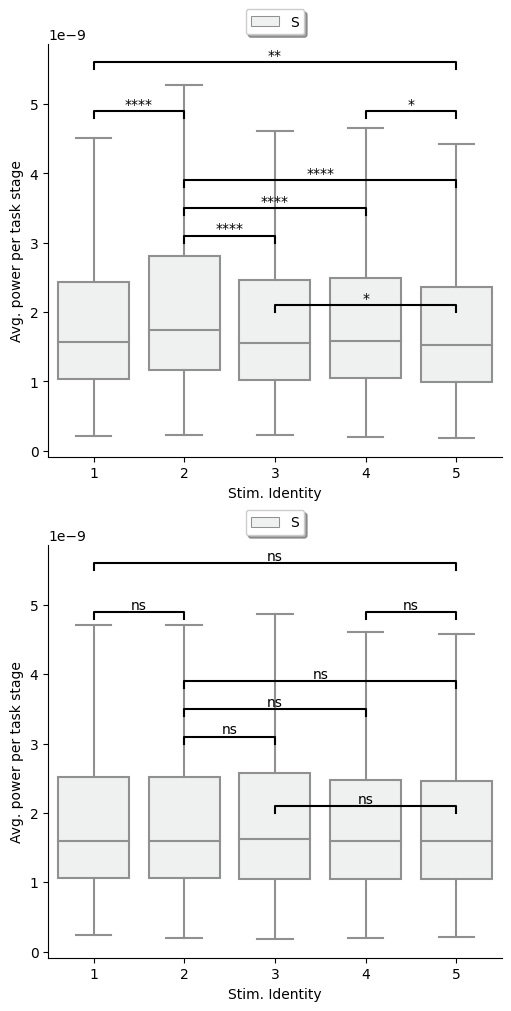

In [33]:
fig, axs = plt.subplot_mosaic([["A"], ["B"]], constrained_layout=True, figsize=(5, 10))

for label, ax in axs.items():
    plt.sca(ax)
    if label == "A":
        plot_dist_V1(df_plot, surrogate=False)
    else:
        plot_dist_V1(df_plot, surrogate=True)

In [34]:
# Pairs of stimulus
stim_pairs = np.stack(np.triu_indices(5, k=1), -1) + 1
n_mod = {}
i = 0
for s_id in tqdm(sessions):
    # Load power
    out, trials, stim = load_session_power(s_id, z_score=False, avg=1)
    # Get area names
    rois = np.unique(out.roi.data)
    # Transform to data frame
    time_labels = dict(zip(range(5), ["P", "S", "D1", "D2", "M"]))
    df_plot = out.sel(freqs=slice(25, 40)).to_dataframe("power").reset_index()
    df_plot["trials"] = df_plot["trials"].map(trial_to_stim)
    df_plot["times"] = df_plot["times"].map(time_labels)
    # Compute p-values between power for diff. stimulus indentities
    for roi in rois:
        p = [
            compute_pval(df_plot.loc[df_plot.roi == roi], "S", s1, s2)
            for s1, s2 in stim_pairs
        ]
        p = np.asarray(p)
        if roi not in n_mod.keys():
            n_mod[roi] = np.zeros(len(sessions))
        n_mod[roi][i] = (p < 0.01).sum()
    i += 1

100%|███████████████████████████████| 62/62 [16:14<00:00, 15.72s/it]


In [21]:
out, trials, stim = load_session_power("141024", z_score=False, avg=1)
# Get area names
rois = np.unique(out.roi.data)
# Transform to data frame
time_labels = dict(zip(range(5), ["P", "S", "D1", "D2", "M"]))
df_plot = out.sel(freqs=slice(25, 40)).to_dataframe("power").reset_index()
df_plot["trials"] = df_plot["trials"].map(trial_to_stim)
df_plot["times"] = df_plot["times"].map(time_labels)

In [22]:
rois = np.asarray(list(n_mod.keys()))
PSI = np.zeros(len(rois))
for i, roi in enumerate(rois):
    PSI[i] = n_mod[roi].sum() / (len(stim_pairs) * len(sessions)) * 100

In [23]:
sid = "141024"

data = [load_session_data(sid) for sid in [sid]][0]

sfreq = data.fsample

power_static, freqs = psd_array_multitaper(
    data.sel(time=slice(0, 0.5)), sfreq, fmin=0, fmax=80, bandwidth=4, n_jobs=20
)

power_static = xr.DataArray(
    power_static,
    dims=("trials", "roi", "freqs"),
    coords=(data.stim.astype(int), data.roi, freqs),
    name="power",
)

    Using multitaper spectrum estimation with 1 DPSS windows


In [24]:
power_static_plot = (
    power_static.groupby("roi").mean("roi").groupby("trials").mean("trials")
)
power_static_plot05 = (
    power_static.groupby("roi").mean("roi").groupby("trials").quantile(0.05, "trials")
)
power_static_plot95 = (
    power_static.groupby("roi").mean("roi").groupby("trials").quantile(0.95, "trials")
)

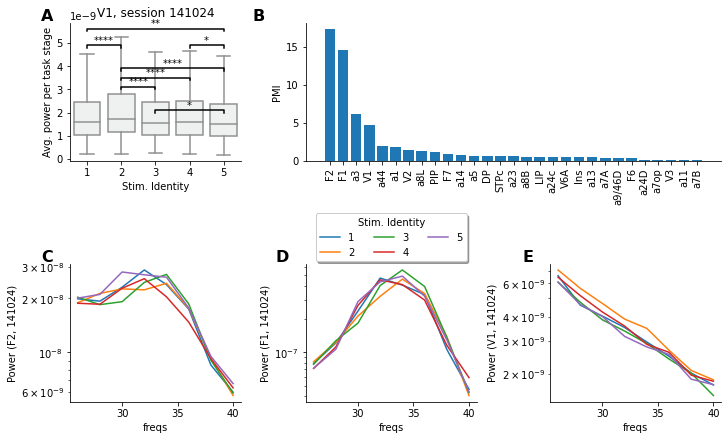

In [25]:
fig, axs = plt.subplot_mosaic(
    [
        ["A", "B", "B"],
        ["C", "D", "E"],
    ],
    constrained_layout=True,
    figsize=(10, 6),
)

for label, ax in axs.items():
    plt.sca(ax)
    if label == "A":
        plot_dist_V1(df_plot, surrogate=False)
        ax.get_legend().remove()

        plt.title("V1, session 141024")
    if label == "B":
        rois = rois[PSI > 0]
        PSI = PSI[PSI > 0]

        sca = np.logical_not(
            (rois == "Putamen")
            + (rois == "Caudate")
            + (rois == "Thal")
            + (rois == "Claustrum")
        )

        rois = rois[sca]
        PSI = PSI[sca]

        idx = np.argsort(PSI)[::-1]
        plt.bar(range(len(rois)), np.sort(PSI)[::-1])
        plt.xticks(range(len(rois)), rois[idx], rotation=90)
        plt.ylabel("PMI")
        # plt.gca().invert_yaxis()
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    elif label == "C":
        power_static_plot.sel(roi="F2", freqs=slice(25, 40)).plot(
            x="freqs", hue="trials", yscale="log", add_legend=False
        )

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        plt.title("")
        plt.ylabel("Power (F2, 141024)")
    elif label == "D":
        power_static_plot.sel(roi="F1", freqs=slice(25, 40)).plot(
            x="freqs", hue="trials", yscale="log", add_legend=True
        )
        ax.legend(
            ["1", "2", "3", "4", "5"],
            loc="upper center",
            bbox_to_anchor=(0.5, 1.4),
            ncol=3,
            fancybox=True,
            shadow=True,
            title="Stim. Identity",
        )
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        plt.title("")
        plt.ylabel("Power (F1, 141024)")
    elif label == "E":
        power_static_plot.sel(roi="V1", freqs=slice(25, 40)).plot(
            x="freqs", hue="trials", yscale="log", add_legend=False
        )
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        plt.ylabel("Power (V1, 141024)")
        plt.title("")

    ax.text(
        -0.1,
        1.1,
        label,
        transform=ax.transAxes,
        fontsize=16,
        fontweight="bold",
        va="top",
        ha="right",
    )

#### Time-resolved rate

In [35]:
import umap
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

2022-10-10 16:19:22.597946: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-10 16:19:23.208424: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-10 16:19:23.445455: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-10 16:19:25.618829: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [36]:
def compute_median_rate(
    data: xr.DataArray,
    roi: str = None,
    thr: float = 3.0,
    stim_label: int = None,
    time_slice: slice = None,
    freqs: float = None,
    n_boot: int = 100,
    verbose: bool = False,
):

    if isinstance(stim_label, int):
        stim_labels = data.stim
        idx_trials = stim_labels == stim_label
    else:
        idx_trials = [True] * data.sizes["trials"]

    # Apply threshold
    data = data >= thr

    # Get time-series
    ts = data.sel(freqs=freqs, times=time_slice, roi=roi).isel(trials=idx_trials)
    times = ts.times.data
    # Stack rois
    if "roi" in ts.dims:
        ts_stacked = ts.stack(z=("trials", "roi")).data
    else:
        ts_stacked = ts.data.T
    n_rois = ts_stacked.shape[0]
    n_trials = ts_stacked.shape[1]
    # Compute bootstraps
    ci = []
    for i in tqdm(range(n_boot)) if verbose else range(n_boot):
        ci += [
            np.take_along_axis(
                ts_stacked,
                np.asarray(
                    [np.random.choice(range(n_trials), n_trials) for _ in range(n_rois)]
                ),
                axis=-1,
            ).mean(-1)
        ]
    ci = np.stack(ci)

    surr = []
    for i in tqdm(range(n_boot)) if verbose else range(n_boot):
        surr += [shuffle_along_axis(ts_stacked, 0)]

    surr = np.stack(surr).mean(-1)

    ci = xr.DataArray(ci, dims=("boot", "times"), coords={"times": times})
    surr = xr.DataArray(surr, dims=("boot", "times"), coords={"times": times})

    return ci, surr

In [37]:
import numba as nb
from frites.utils import parallel_func


def power_correlations(power, verbose=False):

    trials, roi, freqs, times = (
        power.trials.data,
        power.roi.data,
        power.freqs.data,
        power.times.data,
    )
    attrs = power.attrs

    n_trials, n_rois = len(trials), len(roi)

    data = power.data

    pairs = np.stack(np.triu_indices(n_rois, k=1), -1)
    roi_s, roi_t = roi[pairs[:, 0]], roi[pairs[:, 1]]
    edges = [f"{s}-{t}" for s, t in zip(roi_s, roi_t)]
    attrs["sources"], attrs["targets"] = pairs[:, 0], pairs[:, 1]

    @nb.jit(nopython=True)
    def _per_edge(i, j):
        cc = data[:, i, :, :] * data[:, j, :, :]
        return cc

    _iter = pairs
    if verbose:
        _iter = tqdm(_iter)

    cc = np.stack([_per_edge(i, j) for i, j in _iter], 1)

    cc = xr.DataArray(
        cc,
        dims=("trials", "roi", "freqs", "times"),
        coords=(trials, edges, freqs, times),
        attrs=attrs,
    )

    return cc

#### Power

In [38]:
out, trials, stim = load_session_power("141024", z_score=True, avg=0)

In [39]:
# Rate modulation
P_b = []
SP_b = []
rois = np.unique(out.roi.values)
time_slice = slice(-0.5, 2.0)
times = out.sel(times=time_slice).times.data

for roi in tqdm(rois):
    pb, spb = compute_median_rate(
        out.copy(),
        roi,
        stim_label=None,
        time_slice=time_slice,
        freqs=27,
        n_boot=100,
        verbose=False,
    )

    P_b += [pb]
    SP_b += [spb]

100%|███████████████████████████████| 26/26 [01:45<00:00,  4.06s/it]


In [41]:
SP_b = xr.concat(SP_b, "roi")

In [12]:
# Stimulus dependent rate modulation
P_b_stim = []
SP_b_stim = []
for stim in tqdm(range(1, 6)):
    P_b_s = []
    SP_b_s = []
    rois = np.unique(out.roi.values)
    time_slice = slice(-0.5, 2.0)
    times = out.sel(times=time_slice).times.data

    for roi in rois:
        pb, spb = compute_median_rate(
            out.copy(),
            roi,
            stim_label=stim,
            time_slice=time_slice,
            freqs=27,
            n_boot=100,
            verbose=False,
        )

        P_b_s += [pb]
        SP_b_s += [spb]

    P_b_stim += [xr.concat(P_b_s, "roi").assign_coords({"roi": rois})]
    SP_b_stim += [xr.concat(SP_b_s, "roi").assign_coords({"roi": rois})]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:43<00:00, 32.77s/it]


In [13]:
cc = power_correlations(node_xr_remove_sca(out).sel(freqs=[27]), verbose=True)
cc = average_stages(cc, 1)
cc = xr_remove_same_roi(cc)


def convert_to_degree(cc):
    roi_s, roi_t = _extract_roi(cc.roi.data, "-")
    unique_rois = np.unique(np.hstack((roi_s, roi_t)))
    dd = []
    for roi in unique_rois:
        idx = np.logical_or(roi_s == roi, roi_t == roi)
        dd += [cc.isel(roi=idx).sum("roi")]
    dd = xr.concat(dd, "roi").assign_coords({"roi": unique_rois})
    return dd


dd = convert_to_degree(cc)

100%|███████████████████████████████████████████████████████████████████████████████████| 5460/5460 [00:01<00:00, 2768.79it/s]


In [14]:
P_b = xr.concat(P_b, "roi")
P_b = P_b.assign_coords({"roi": rois})
SP_b = xr.concat(SP_b, "roi")
SP_b = SP_b.assign_coords({"roi": rois})

In [15]:
P_b_stim = xr.concat(P_b_stim, "stim")
SP_b_stim = xr.concat(SP_b_stim, "stim")

p = P_b_stim.quantile(0.5, "boot")
t_d = P_b.quantile(0.05, "boot")
t_u = P_b.quantile(0.95, "boot")

rmi = ((p > t_u) + (p < t_d)).mean("times").mean("stim")

In [16]:
X = P_b.median("boot")

In [17]:
# Number of clusters to use
n_clusters = np.arange(2, 21, 1, dtype=int)
# Silhouette score
se = np.zeros_like(n_clusters, dtype=float)
for i, nc in enumerate(n_clusters):
    kmeans = KMeans(n_clusters=nc, random_state=0).fit(X.data)
    se[i] = silhouette_score(X, kmeans.labels_, metric="euclidean")

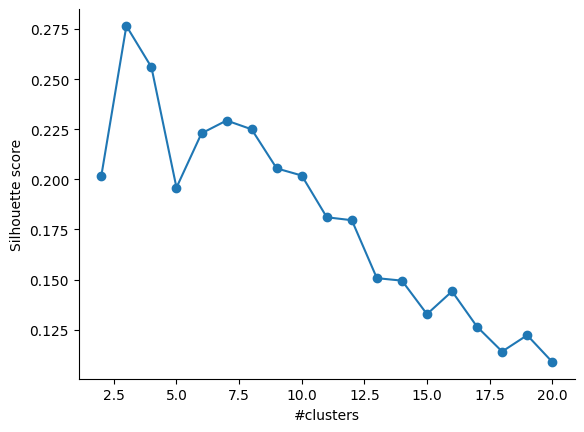

In [18]:
ax = plt.subplot(111)
plt.plot(n_clusters, se, "o-")
plt.ylabel("Silhouette score")
plt.xlabel("#clusters")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

In [19]:
X = node_xr_remove_sca(X)

In [20]:
X_embedded = umap.UMAP(n_neighbors=5, min_dist=1, random_state=20).fit_transform(X.data)

labels = kmeans = (
    KMeans(n_clusters=4, random_state=10, init="random").fit(X.data).labels_
)

colors = ["r", "b", "g", "m"]

times = X.times.data.astype(np.float32)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [21]:
idx = labels.argsort()

In [22]:
def plot_rate(label, color):
    idx = labels == label
    rate = P_b.isel(roi=idx).mean("roi")
    surr_rate = (
        P_b.isel(roi=idx).sel(times=slice(-0.45, -0.1)).mean("roi")
    )  # SP_b.isel(roi=idx).mean("roi")
    plt.step(P_b.times, np.quantile(rate, 0.5, 0), color=color)
    plt.fill_between(
        P_b.times,
        np.quantile(rate, 0.05, axis=0),
        np.quantile(rate, 0.95, axis=0),
        color=color,
        step="pre",
        alpha=0.2,
    )

    plt.fill_between(
        P_b.times,
        surr_rate.quantile(0.05, ("boot", "times")),
        surr_rate.quantile(0.95, ("boot", "times")),
        color="lightgray",
        alpha=0.6,
    )
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.ylabel(r"$P_t[B]$")
    plt.xlabel("Time [s]")


def plot_cc_tpower(j):
    colors = ["r", "b", "g", "m"]
    stage = ["S", "D1", "D2", "M"]
    for i in range(dd.sizes["roi"]):
        plt.scatter(
            dd.isel(roi=i, times=j), t_power.isel(roi=i, times=j), c=colors[l[i]]
        )
        if dd.roi.data[i] == "V1":
            plt.text(
                dd.isel(roi=i, times=j) + 0.1,
                t_power.isel(roi=i, times=j) + 0.1,
                dd.roi.data[i],
            )
        elif dd.roi.data[i] == "V2":
            plt.text(
                dd.isel(roi=i, times=j) + 0.1,
                t_power.isel(roi=i, times=j) + 0.1,
                dd.roi.data[i],
            )
    [ax.spines[key].set_visible(False) for key in ["top", "right"]]
    plt.xlabel("CC strength")
    plt.ylabel("t-power")
    plt.title(f"{stage[j - 1]}")

In [23]:
path = os.path.expanduser("~/funcog/gda/Results/lucy/mutual_information/power")
t_power = xr.load_dataarray(
    os.path.join(path, "tval_pow_1_br_1_aligned_cue_avg_1_fdr.nc")
)
t_power = t_power.sel(roi=P_b.roi, freqs=27)
dd = dd.sel(roi=P_b.roi, freqs=27).mean("trials")

In [24]:
labels_dict = dict(zip(P_b.roi.data, labels))

In [25]:
l = []
for roi in t_power.roi.data:
    l += [labels_dict[roi]]

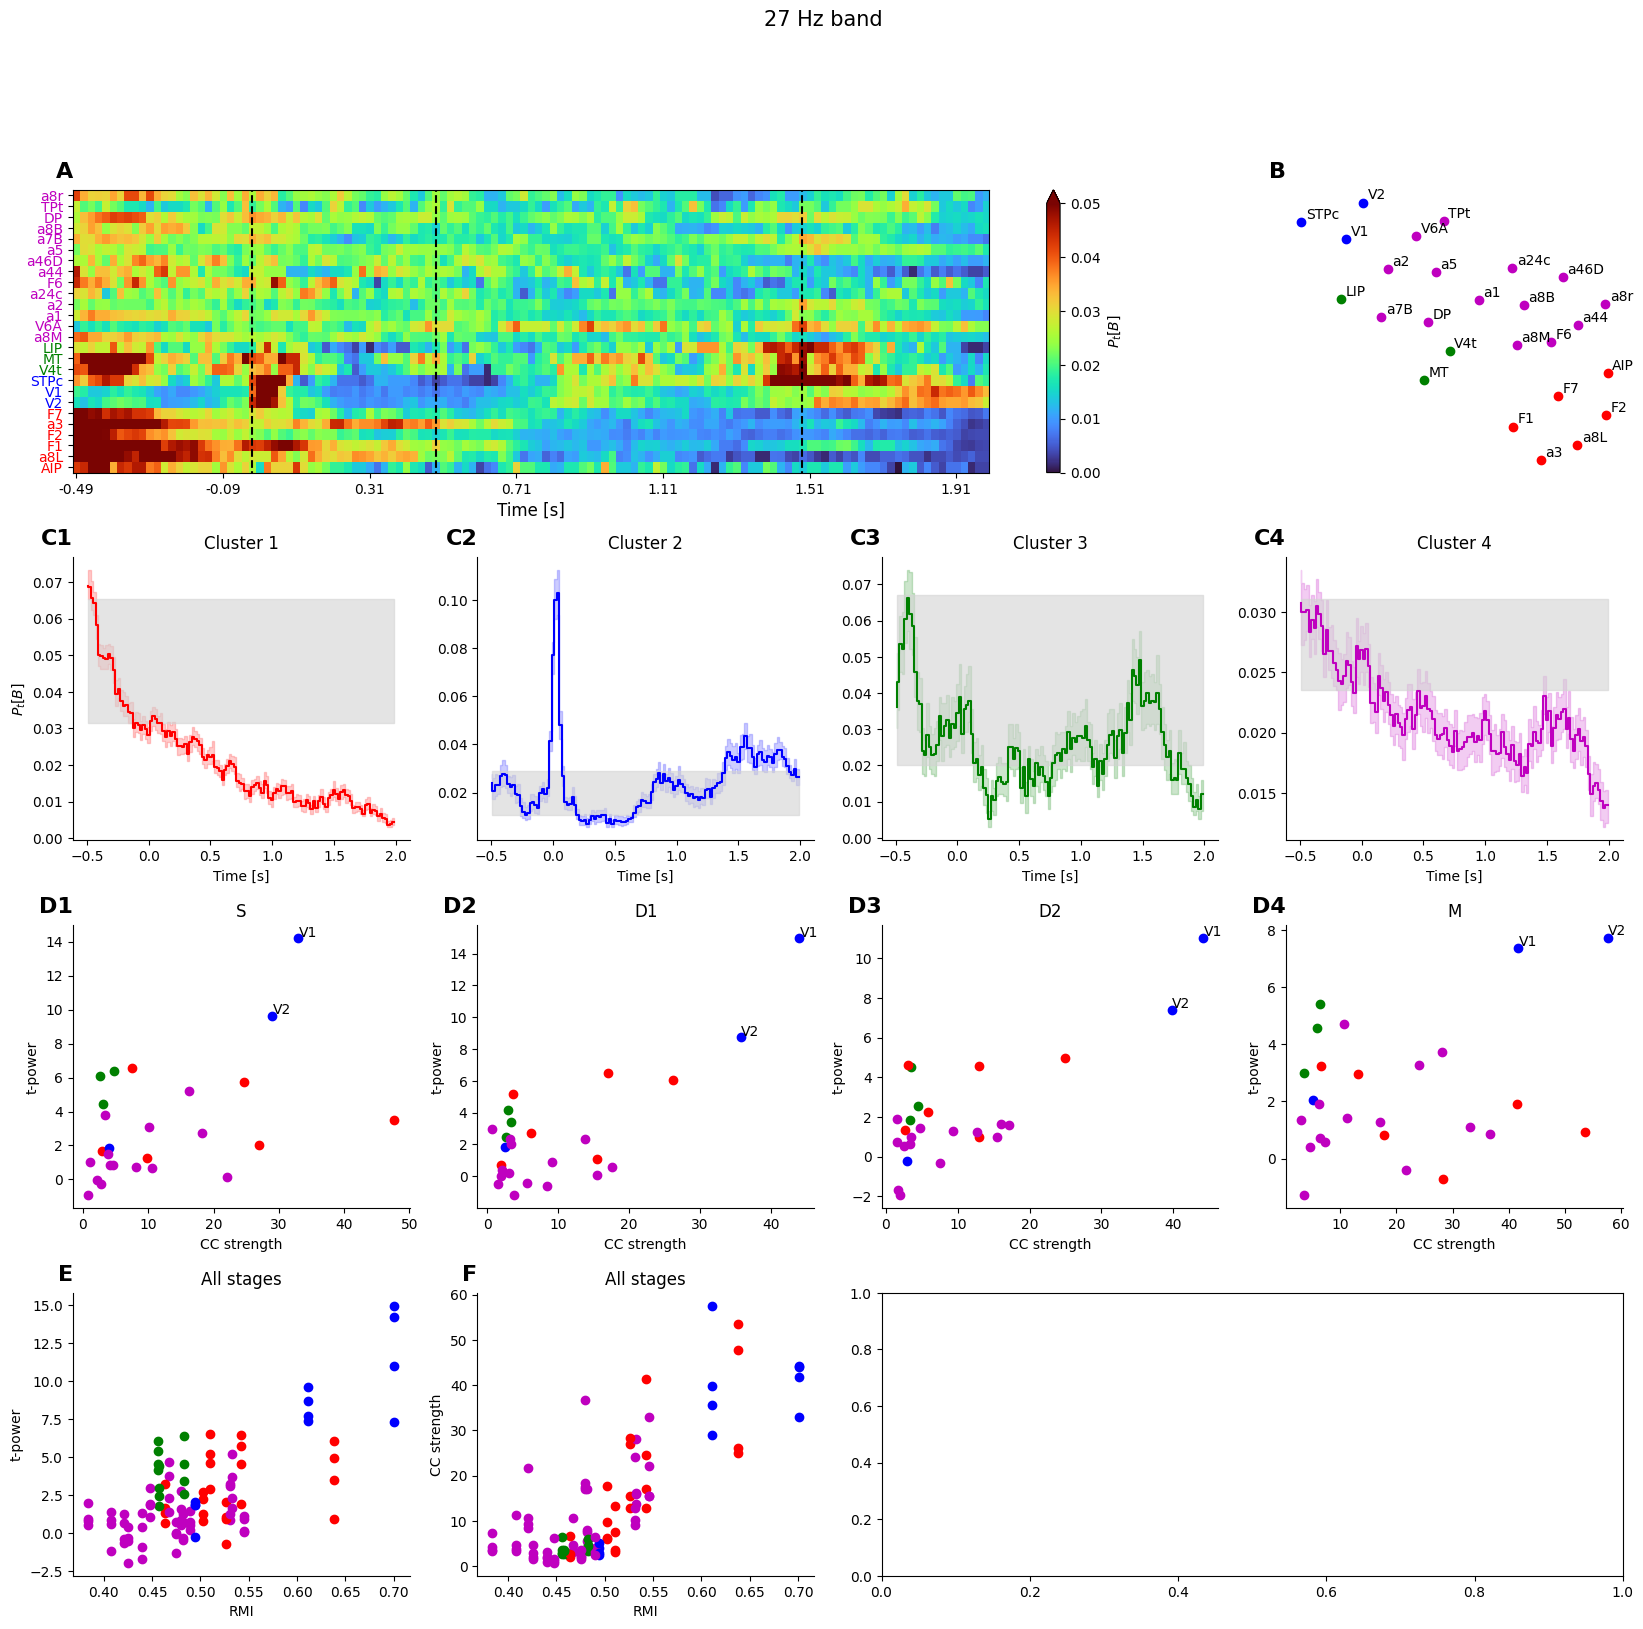

In [26]:
fig, axs = plt.subplot_mosaic(
    [
        ["A", "A", "A", "B"],
        ["C1", "C2", "C3", "C4"],
        ["D1", "D2", "D3", "D4"],
        ["E", "F", "G", "G"],
    ],
    constrained_layout=False,
    figsize=(20, 18),
)

for label, ax in axs.items():

    if label == "G":
        continue

    plt.sca(ax)

    if label == "A":
        plt.imshow(
            X[idx, :], aspect="auto", cmap="turbo", origin="lower", vmin=0, vmax=0.05
        )
        cbar = plt.colorbar(extend="max")
        cbar.ax.set_ylabel(r"$P_t[B]$", rotation=90, fontsize=10)
        x_ticks_idx = ax.get_xticks()[1:-1].astype(int)
        plt.xticks(x_ticks_idx, times[x_ticks_idx])
        tks = plt.yticks(range(P_b.sizes["roi"]), P_b.roi.data[idx])
        [tks[1][i].set_color(colors[labels[idx][i]]) for i in range(P_b.sizes["roi"])]
        plt.xlabel("Time [s]", fontsize=12)
        ax.axvline(
            np.abs(0 - times).argmin(), -0.1, X.sizes["roi"] - 1, color="k", ls="--"
        )
        ax.axvline(
            np.abs(0.5 - times).argmin(), -0.1, X.sizes["roi"] - 1, color="k", ls="--"
        )
        ax.axvline(
            np.abs(1.5 - times).argmin(), -0.1, X.sizes["roi"] - 1, color="k", ls="--"
        )
    if label == "B":
        for i in range(len(X_embedded)):
            plt.scatter(X_embedded[i, 0], X_embedded[i, 1], color=colors[labels[i]])
            plt.text(X_embedded[i, 0] + 0.1, X_embedded[i, 1] + 0.1, X.roi.data[i])
        plt.xticks([])
        plt.yticks([])
        [ax.spines[key].set_visible(False) for key in ax.spines.keys()]
    if label == "C1":
        plot_rate(0, colors[0])
        plt.title("Cluster 1")
    if label == "C2":
        plot_rate(1, colors[1])
        plt.title("Cluster 2")
        plt.ylabel("")
    if label == "C3":
        plot_rate(2, colors[2])
        plt.title("Cluster 3")
        plt.ylabel("")
    if label == "C4":
        plot_rate(3, colors[3])
        plt.title("Cluster 4")
        plt.ylabel("")
    if label == "D1":
        plot_cc_tpower(1)
    if label == "D2":
        plot_cc_tpower(2)
    if label == "D3":
        plot_cc_tpower(3)
    if label == "D4":
        plot_cc_tpower(4)
    if label == "E":
        for j in range(1, 5):
            for i in range(dd.sizes["roi"]):
                plt.scatter(
                    rmi.isel(roi=i),
                    t_power.sel(times=j).isel(roi=i),
                    c=colors[l[i]],
                )
        [ax.spines[key].set_visible(False) for key in ["top", "right"]]
        plt.xlabel("RMI")
        plt.ylabel("t-power")
        plt.title("All stages")
    if label == "F":
        for j in range(1, 5):
            for i in range(dd.sizes["roi"]):
                plt.scatter(
                    rmi.isel(roi=i),
                    dd.sel(times=j).isel(roi=i),
                    c=colors[l[i]],
                )
        [ax.spines[key].set_visible(False) for key in ["top", "right"]]
        plt.xlabel("RMI")
        plt.ylabel("CC strength")
        plt.title("All stages")

    ax.text(
        0.0,
        1.1,
        label,
        transform=ax.transAxes,
        fontsize=16,
        fontweight="bold",
        va="top",
        ha="right",
    )
    plt.suptitle("27 Hz band", fontsize=15)
plt.subplots_adjust(hspace=0.3)

In [35]:
from GDa.stats.bursting import tensor_burstness_stats
from GDa.util import create_stages_time_grid

In [36]:
early_cue = 0.2
early_delay = 0.3
s_mask = create_stages_time_grid(
    out.t_cue_on - early_cue * out.fsample,
    out.t_cue_off,
    out.t_match_on,
    out.fsample,
    out.times.data,
    out.sizes["trials"],
    early_delay=early_delay,
    align_to="cue",
    flatten=False,
)

In [69]:
n_samp = []
for key in s_mask.keys():
    n_samp += [s_mask[key].sum()]

In [180]:
bst = tensor_burstness_stats(
    np.transpose((out.sel(freqs=27).data >= 3), (1, 0, 2)),
    s_mask,
    drop_edges=True,
    find_zeros=True,
    samples=n_samp,
    dt=np.diff(out.times)[0],
)

  0%|          |  : 0/105 [00:00<?,       ?it/s]

  0%|          |  : 0/105 [00:00<?,       ?it/s]

  0%|          |  : 0/105 [00:00<?,       ?it/s]

  0%|          |  : 0/105 [00:00<?,       ?it/s]

  0%|          |  : 0/105 [00:00<?,       ?it/s]

In [181]:
bst = xr.DataArray(
    bst[..., -1], dims=("roi", "times"), coords={"roi": out.roi}, name="bst"
)

In [182]:
bst = node_xr_remove_sca(bst)

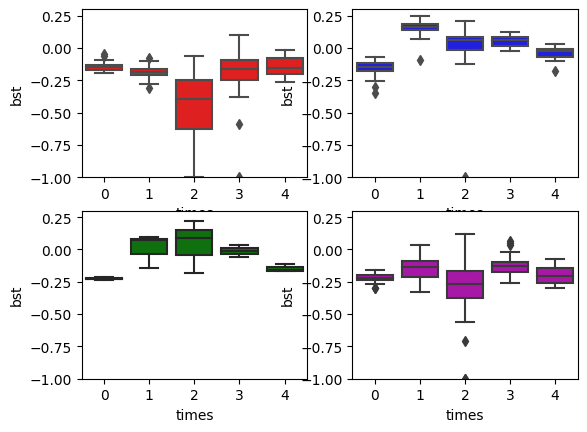

In [205]:
for l in np.unique(labels):
    bst_ = xr.concat([bst.sel(roi=r) for r in P_b.roi[labels == l].data], "roi")
    plt.subplot(2, 2, l + 1)
    sns.boxplot(
        data=bst_.to_dataframe().reset_index(),
        x="times",
        y="bst",
        color=colors[l],
    )
    plt.ylim(-1, 0.3)

#### Coherence

In [206]:
out, trials, stim = load_session_coherence("141024", z_score=True, avg=0)
attrs = out.attrs
out = out.sel(freqs=slice(25, 40))
out.attrs = attrs
out = edge_xr_remove_sca(xr_remove_same_roi(out))

In [564]:
P_b = []
SP_b = []
rois = np.unique(out.roi.values)
time_slice = slice(-0.5, 2.0)
times = out.sel(times=time_slice).times.data

for roi in tqdm(rois):
    pb, spb = compute_median_rate(
        out.copy(),
        roi,
        time_slice=time_slice,
        freqs=27,
        n_boot=100,
        verbose=False,
    )

    P_b += [pb]
    SP_b += [spb]

100%|█████████████████████████████████████████████████████████████████████████████████████| 325/325 [1:26:00<00:00, 15.88s/it]


In [565]:
P_b_stim = []
SP_b_stim = []
for stim in range(1, 6):
    P_b_s = []
    SP_b_s = []
    rois = np.unique(out.roi.values)
    time_slice = slice(-0.5, 2.0)
    times = out.sel(times=time_slice).times.data

    for roi in tqdm(rois):
        pb, spb = compute_median_rate(
            out.copy(),
            roi,
            stim_label=stim,
            time_slice=time_slice,
            freqs=27,
            n_boot=100,
            verbose=False,
        )

        P_b_s += [pb]
        SP_b_s += [spb]

    P_b_stim += [xr.concat(P_b_s, "roi").assign_coords({"roi": rois})]
    SP_b_stim += [xr.concat(SP_b_s, "roi").assign_coords({"roi": rois})]

100%|███████████████████████████████████████████████████████████████████████████████████████| 325/325 [26:11<00:00,  4.84s/it]


In [566]:
P_b = xr.concat(P_b, "roi")
P_b = P_b.assign_coords({"roi": rois})
SP_b = xr.concat(SP_b, "roi")
SP_b = SP_b.assign_coords({"roi": rois})

In [567]:
P_b_stim = xr.concat(P_b_stim, "stim")
SP_b_stim = xr.concat(SP_b_stim, "stim")

In [309]:
# P_b.to_netcdf("ptb_coh.nc")
# SP_b.to_netcdf("sptb_coh.nc")
P_b = xr.load_dataarray("ptb_coh.nc")
SP_b = xr.load_dataarray("sptb_coh.nc")

# P_b_stim.to_netcdf("pb_stim_coh.nc")
# SP_b_stim.to_netcdf("spb_stim_coh.nc")

P_b_stim = xr.load_dataarray("pb_stim_coh.nc")
SP_b_stim = xr.load_dataarray("spb_stim_coh.nc")

In [310]:
p = P_b_stim.quantile(0.5, "boot")
t_d = P_b.quantile(0.05, "boot")
t_u = P_b.quantile(0.95, "boot")

rmi = ((p > t_u) + (p < t_d)).mean("times").mean("stim")

In [311]:
path = os.path.expanduser("~/funcog/gda/Results/lucy/mutual_information/coherence")
t_coh = xr.load_dataarray(os.path.join(path, "tval_coh_avg_1_fdr.nc"))

t_coh_rois = []
rois = []
for roi in p.roi.data:
    if roi in t_coh.roi:
        t_coh_rois += [t_coh.sel(roi=roi, freqs=27)]
        rois += [roi]

t_coh_rois = xr.concat(t_coh_rois, "roi").assign_coords({"roi": rois})

In [312]:
path_ent = os.path.expanduser("~/funcog/gda/Results/lucy/meta_conn")
ent = xr.load_dataarray(os.path.join(path_ent, "ent_coh_141024.nc"))

ent = edge_xr_remove_sca(xr_remove_same_roi(ent))

ent = ent.sel(freqs=27).groupby("roi").mean("roi").sel(roi=t_coh_rois.roi)

In [313]:
X = P_b.median("boot")

In [314]:
# Number of clusters to use
n_clusters = np.arange(2, 21, 1, dtype=int)
# Silhouette score
se = np.zeros_like(n_clusters, dtype=float)
for i, nc in enumerate(n_clusters):
    kmeans = KMeans(n_clusters=nc, random_state=0).fit(X.data)
    se[i] = silhouette_score(X, kmeans.labels_, metric="euclidean")

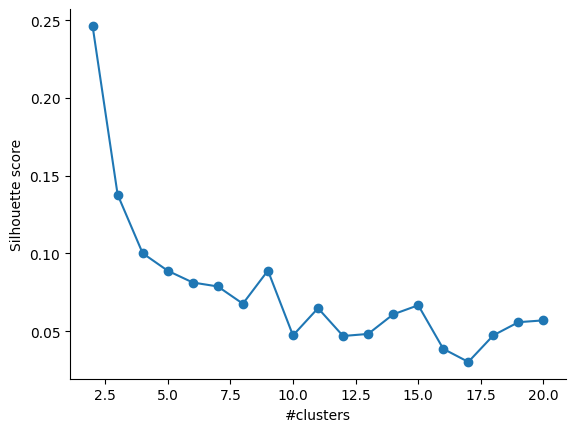

In [315]:
ax = plt.subplot(111)
plt.plot(n_clusters, se, "o-")
plt.ylabel("Silhouette score")
plt.xlabel("#clusters")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

In [316]:
X_embedded = umap.UMAP(n_neighbors=5, min_dist=1, random_state=20).fit_transform(X.data)

labels = kmeans = KMeans(n_clusters=4, random_state=0).fit(X.data).labels_

colors = ["r", "b", "g", "m"]

times = X.times.data.astype(np.float32)

In [317]:
labels_dict = dict(zip(P_b.roi.data, labels))

l = []
for roi in t_coh_rois.roi.data:
    l += [labels_dict[roi]]

In [318]:
idx = labels.argsort()

In [319]:
unique_rois = np.unique(np.hstack(_extract_roi(P_b.roi.data, "-")))
incidence = xr.DataArray(
    np.zeros((len(unique_rois), labels.max() + 1)),
    dims=("roi", "cluster"),
    coords={"roi": unique_rois},
)

for i in range(labels.max() + 1):
    unique_rois_label, counts = np.unique(
        np.hstack(_extract_roi(P_b.roi.data[labels == i], "-")), return_counts=True
    )
    for j, roi in enumerate(unique_rois_label):
        if roi in incidence.roi.data:
            incidence[j, i] = counts[j]
data = incidence / incidence.sum("cluster")

In [320]:
early_cue = 0.2
early_delay = 0.3
s_mask = create_stages_time_grid(
    out.t_cue_on - early_cue * out.fsample,
    out.t_cue_off,
    out.t_match_on,
    out.fsample,
    out.times.data,
    out.sizes["trials"],
    early_delay=early_delay,
    align_to="cue",
    flatten=False,
)

n_samp = []
for key in s_mask.keys():
    n_samp += [s_mask[key].sum()]

bst = tensor_burstness_stats(
    np.transpose((out.sel(freqs=27).data >= 3), (1, 0, 2)),
    s_mask,
    drop_edges=True,
    find_zeros=True,
    samples=n_samp,
    dt=np.diff(out.times)[0],
)

bst = xr.DataArray(
    bst[..., -1], dims=("roi", "times"), coords={"roi": out.roi}, name="bst"
)

  0%|          |  : 0/5115 [00:00<?,       ?it/s]

  0%|          |  : 0/5115 [00:00<?,       ?it/s]

  0%|          |  : 0/5115 [00:00<?,       ?it/s]

  0%|          |  : 0/5115 [00:00<?,       ?it/s]

  0%|          |  : 0/5115 [00:00<?,       ?it/s]

/home/vinicius/storage1/projects/GrayData-Analysis/GDa/stats/bursting.py:314: RuntimeWarning: Mean of empty slice
  bs_stats[:, idx, 0] = np.nanmean(out[key], axis=-1)
/home/vinicius/anaconda3/envs/gda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [321]:
def plot_ent_tcoh(j):
    colors = ["r", "b", "g", "m"]
    stage = ["S", "D1", "D2", "M"]
    for i in range(ent.sizes["roi"]):
        plt.scatter(
            ent.isel(roi=i, times=j), t_coh_rois.isel(roi=i, times=j), c=colors[l[i]]
        )
        if ent.roi.data[i] == "F1-V1":
            plt.text(
                ent.isel(roi=i, times=j) + 0.1,
                t_coh_rois.isel(roi=i, times=j) + 0.1,
                ent.roi.data[i],
            )
    [ax.spines[key].set_visible(False) for key in ["top", "right"]]
    plt.xlabel("CC strength")
    plt.ylabel("t-coh")
    plt.title(f"{stage[j - 1]}")


def plot_bursting(label):
    bst_ = xr.concat([bst.sel(roi=r) for r in P_b.roi[labels == label].data], "roi")
    ax = sns.violinplot(
        data=bst_.to_dataframe().reset_index(),
        x="times",
        y="bst",
        color=colors[label],
        showfliers=False,
        inner="box",
        scale="count",
        trim=True,
    )
    plt.setp(ax.collections, alpha=0.6)

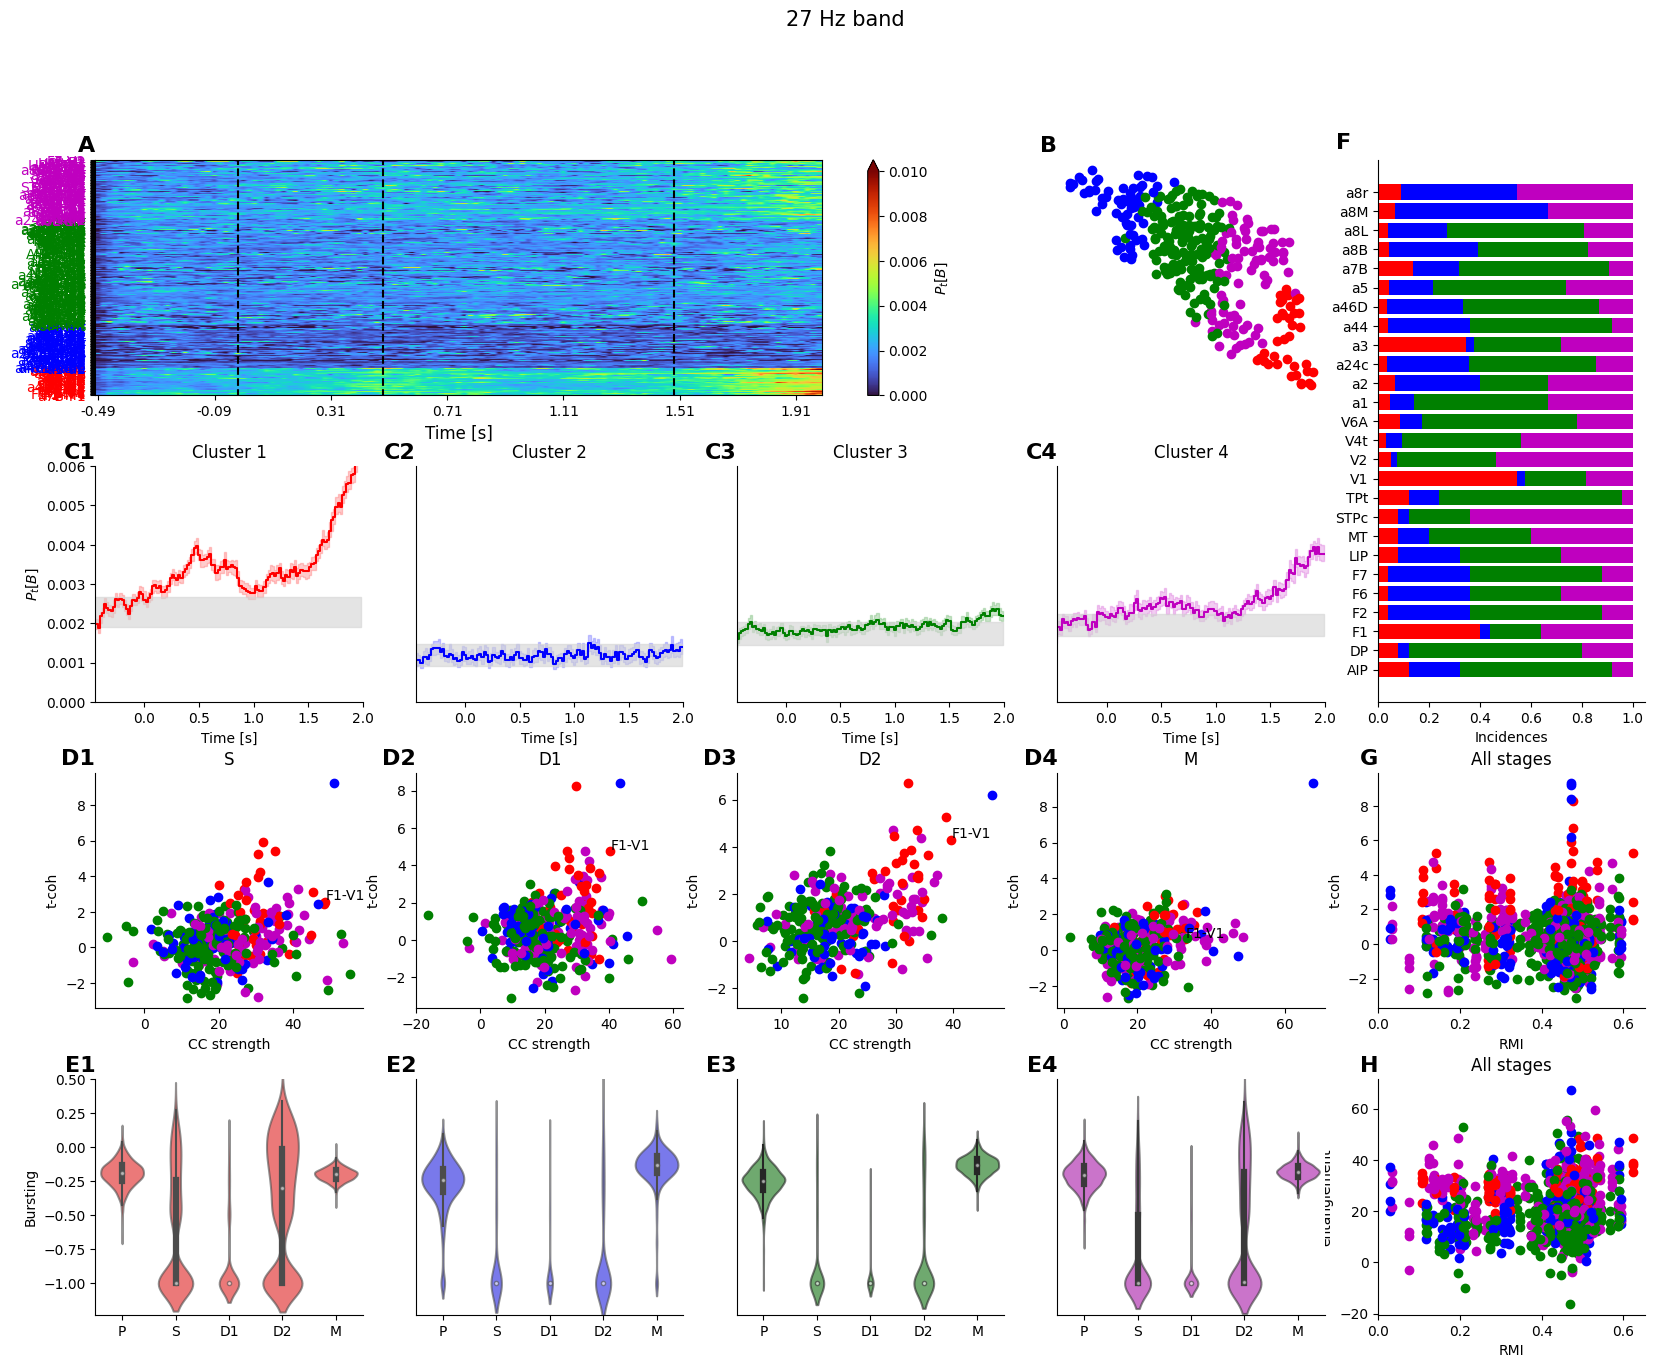

In [322]:
fig, axs = plt.subplot_mosaic(
    [
        ["A", "A", "A", "B", "F"],
        ["C1", "C2", "C3", "C4", "F"],
        ["D1", "D2", "D3", "D4", "G"],
        ["E1", "E2", "E3", "E4", "H"],
    ],
    constrained_layout=False,
    figsize=(20, 15),
)

for label, ax in axs.items():
    plt.sca(ax)

    if label == "A":
        plt.imshow(
            X[idx, :], aspect="auto", cmap="turbo", origin="lower", vmin=0, vmax=0.01
        )
        cbar = plt.colorbar(extend="max")
        cbar.ax.set_ylabel(r"$P_t[B]$", rotation=90, fontsize=10)
        x_ticks_idx = ax.get_xticks()[1:-1].astype(int)
        plt.xticks(x_ticks_idx, times[x_ticks_idx])
        tks = plt.yticks(range(P_b.sizes["roi"]), P_b.roi.data[idx])
        [tks[1][i].set_color(colors[labels[idx][i]]) for i in range(P_b.sizes["roi"])]
        plt.xlabel("Time [s]", fontsize=12)
        ax.axvline(
            np.abs(0 - times).argmin(), -0.1, X.sizes["roi"] - 1, color="k", ls="--"
        )
        ax.axvline(
            np.abs(0.5 - times).argmin(), -0.1, X.sizes["roi"] - 1, color="k", ls="--"
        )
        ax.axvline(
            np.abs(1.5 - times).argmin(), -0.1, X.sizes["roi"] - 1, color="k", ls="--"
        )
    if label == "B":
        for i in range(len(X_embedded)):
            plt.scatter(X_embedded[i, 0], X_embedded[i, 1], color=colors[labels[i]])
        plt.xticks([])
        plt.yticks([])
        [ax.spines[key].set_visible(False) for key in ax.spines.keys()]
    if label == "C1":
        plot_rate(0, colors[0])
        plt.xlim(-0.45, 2)
        plt.title("Cluster 1")
    if label == "C2":
        plot_rate(1, colors[1])
        plt.xlim(-0.45, 2)
        plt.title("Cluster 2")
        plt.yticks([])
        plt.ylabel("")
    if label == "C3":
        plot_rate(2, colors[2])
        plt.xlim(-0.45, 2)
        plt.title("Cluster 3")
        plt.yticks([])
        plt.ylabel("")
    if label == "C4":
        plot_rate(3, colors[3])
        plt.xlim(-0.45, 2)
        plt.title("Cluster 4")
        plt.yticks([])
        plt.ylabel("")
    if label == "F":
        x_ticks = range(data.sizes["roi"])
        for i in [3, 2, 1, 0]:
            plt.barh(x_ticks, data[:, i] + data[:, :i].sum("cluster"), color=colors[i])
        plt.yticks(x_ticks, data.roi.data)
        plt.xlabel("Incidences")
        [ax.spines[key].set_visible(False) for key in ["top", "right"]]

    if label == "D1":
        plot_ent_tcoh(1)
    if label == "D2":
        plot_ent_tcoh(2)
    if label == "D3":
        plot_ent_tcoh(3)
    if label == "D4":
        plot_ent_tcoh(4)

    if label == "E1":
        plot_bursting(0)
        [ax.spines[key].set_visible(False) for key in ["top", "right"]]
        plt.ylabel("Bursting")
        plt.xlabel("")
        plt.ylim(-1.23, 0.5)
        plt.xticks(range(5), ["P", "S", "D1", "D2", "M"])
    if label == "E2":
        plot_bursting(1)
        [ax.spines[key].set_visible(False) for key in ["top", "right"]]
        plt.ylabel("")
        plt.xlabel("")
        plt.ylim(-1.23, 0.5)
        plt.yticks([])
        plt.xticks(range(5), ["P", "S", "D1", "D2", "M"])
    if label == "E3":
        plot_bursting(2)
        [ax.spines[key].set_visible(False) for key in ["top", "right"]]
        plt.ylabel("")
        plt.xlabel("")
        plt.ylim(-1.23, 0.5)
        plt.yticks([])
        plt.xticks(range(5), ["P", "S", "D1", "D2", "M"])
    if label == "E4":
        plot_bursting(3)
        [ax.spines[key].set_visible(False) for key in ["top", "right"]]
        plt.ylabel("")
        plt.xlabel("")
        plt.ylim(-1.23, 0.5)
        plt.yticks([])
        plt.xticks(range(5), ["P", "S", "D1", "D2", "M"])

    if label == "G":
        for j in range(1, 5):
            for i in range(ent.sizes["roi"]):
                plt.scatter(
                    rmi.isel(roi=i),
                    t_coh_rois.sel(times=j).isel(roi=i),
                    c=colors[l[i]],
                )
        [ax.spines[key].set_visible(False) for key in ["top", "right"]]
        plt.xlabel("RMI")
        plt.ylabel("t-coh")
        plt.title("All stages")

    if label == "H":
        for j in range(1, 5):
            for i in range(ent.sizes["roi"]):
                plt.scatter(
                    rmi.isel(roi=i),
                    ent.sel(times=j).isel(roi=i),
                    c=colors[l[i]],
                )
        [ax.spines[key].set_visible(False) for key in ["top", "right"]]
        plt.xlabel("RMI")
        plt.ylabel("entanglement")
        plt.title("All stages")

    if label in ["C1", "C2", "C3", "C4"]:
        plt.ylim(0, 0.006)
    if label == "F":
        y_pos = 1.05
        x_pos = -0.1
    else:
        y_pos = 1.1
        x_pos = 0
    ax.text(
        x_pos,
        y_pos,
        label,
        transform=ax.transAxes,
        fontsize=16,
        fontweight="bold",
        va="top",
        ha="right",
    )
    plt.suptitle("27 Hz band", fontsize=15)
plt.subplots_adjust(hspace=0.3)

In [11]:
def transprob(aval):  # (t,r)
    mat = np.zeros((nregions, nregions))
    norm = np.sum(aval, axis=0)
    for t in range(len(aval) - 1):
        ini = np.where(aval[t] == 1)
        mat[ini] += aval[t + 1]
    mat[norm != 0] = mat[norm != 0] / norm[norm != 0][:, None]
    return mat


def Transprob(ZBIN):  # (t,r)
    mat = np.zeros((nregions, nregions))
    A = np.sum(ZBIN, axis=1)
    a = np.arange(len(ZBIN))
    idx = np.where(A != 0)[0]
    aout = np.split(a[idx], np.where(np.diff(idx) != 1)[0] + 1)
    ifi = 0
    for iaut in range(len(aout)):
        if len(aout[iaut]) > 2:
            mat += transprob(ZBIN[aout[iaut]])
            ifi += 1
    mat = mat / ifi
    return mat

In [12]:
nregions = out.sizes["roi"]

In [13]:
ZBIN = out.sel(freqs=27, times=slice(1, 2)) >= 3

In [14]:
ZBIN[0].shape

(105, 50)

In [15]:
tm = [Transprob(ZBIN[i, ...].data.T) for i in range(ZBIN.sizes["trials"])]

In [16]:
tm = np.stack(tm, 0)

In [17]:
tm = xr.DataArray(
    tm, dims=("trials", "sources", "targets"), coords=(out.trials, out.roi, out.roi)
)

In [18]:
tm = tm.assign_coords({"trials": out.stim.astype(int)})

In [19]:
mat = tm.groupby("trials").mean("trials")

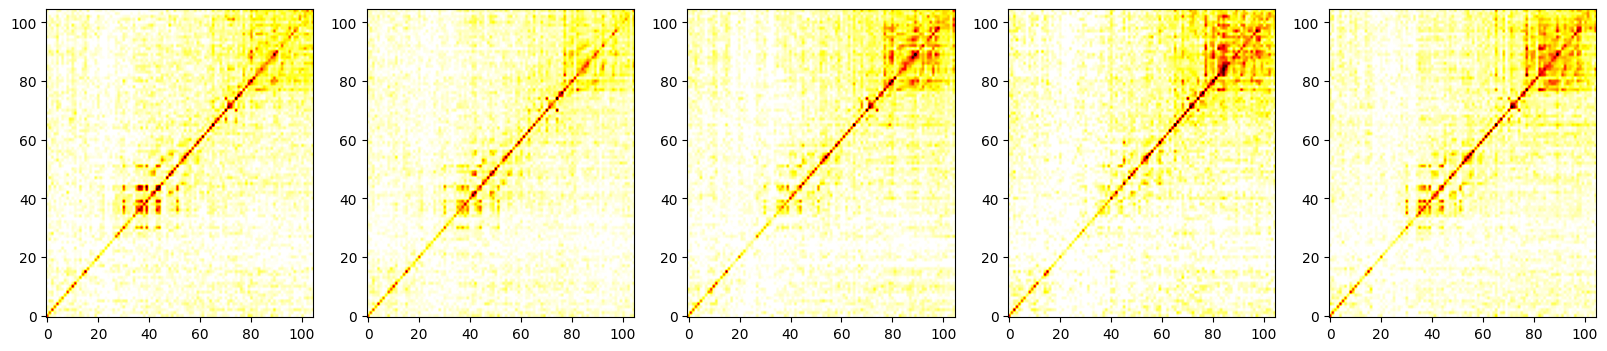

In [20]:
plt.figure(figsize=(20, 4))

for i in range(1, 6):
    plt.subplot(1, 5, i)
    plt.imshow(mat[i - 1], aspect="auto", cmap="hot_r", origin="lower", vmax=0.05)

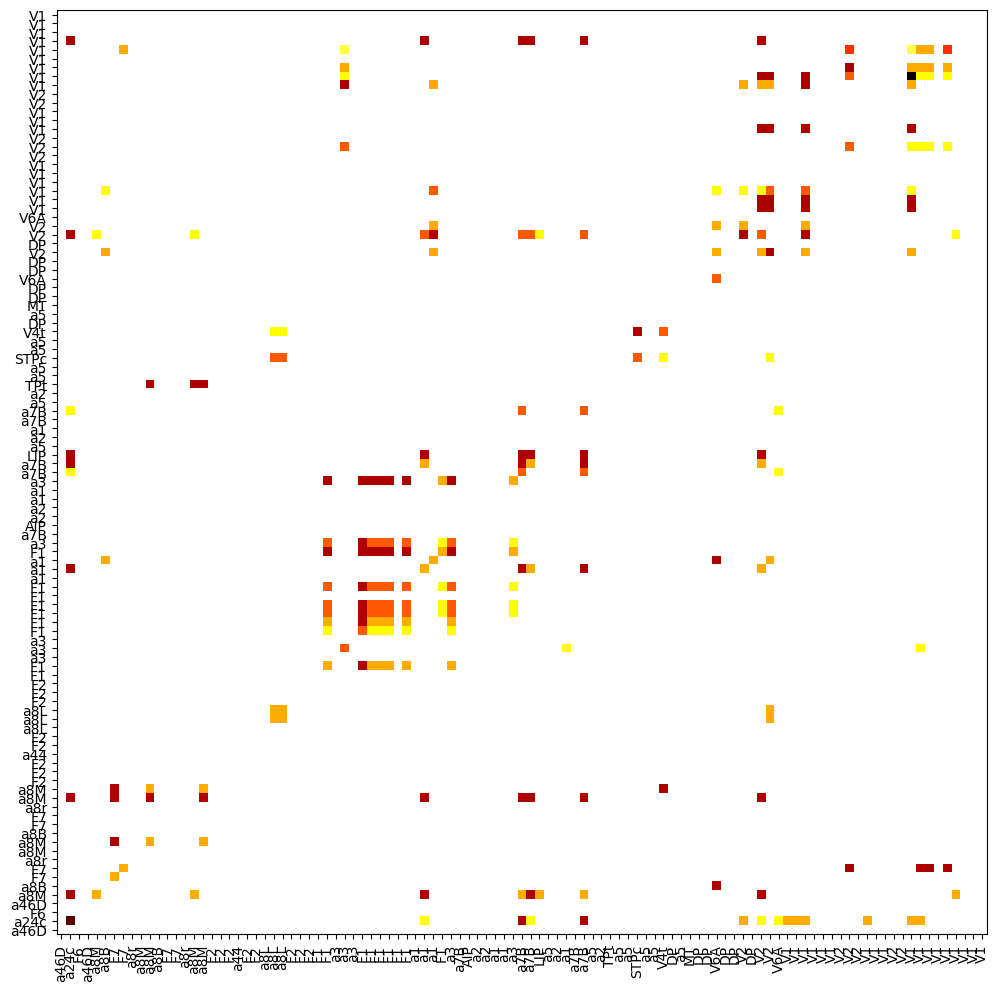

In [21]:
plt.figure(figsize=(12, 12))
plt.imshow(tm[2], aspect="auto", cmap="hot_r", origin="lower")
plt.yticks(range(105), tm.sources.data)
plt.xticks(range(105), tm.targets.data, rotation=90);

### Classifier

In [258]:
import matplotlib.pyplot as plt
from brainconn.centrality import eigenvector_centrality_und
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [280]:
out, trials, stim = load_session_coherence("141024", z_score=True, avg=0)
attrs = out.attrs
out.attrs = attrs
out = edge_xr_remove_sca(xr_remove_same_roi(out))

In [294]:
bands = {
    "alpha": [6, 14],
    "beta": [14, 26],
    "high_beta": [26, 43],
    "gamma": [43, 80],
}


def compute_cv_scores(time_slice, band, shuffle=False):

    f_0, f_1 = bands[band][0], bands[band][1]

    X = (
        out.groupby("roi")
        .mean("roi")
        .sel(freqs=slice(f_0, f_1), times=time_slice)
        .mean("times")
        .assign_coords({"trials": stim.astype(int)})
        .stack(z=("freqs", "trials"))
    )

    y = X.trials.data
    X = X.data

    if shuffle:
        np.random.shuffle(y)

    x_train, x_test, y_train, y_test = train_test_split(
        X.T, y, test_size=0.33, shuffle=True
    )

    max_depths = np.arange(1, 21, 1, dtype=int)
    n_estimators = [100, 200, 500, 1000]
    max_features = ["sqrt", X.shape[0]]

    parameters = {
        "n_estimators": n_estimators,
        "max_features": max_features,
        "ccp_alpha": [0, 0.001, 0.01, 0.1],
    }

    est = RandomForestClassifier(n_jobs=20, bootstrap=True)

    clf = GridSearchCV(
        estimator=est,
        param_grid=parameters,
        cv=5,
        scoring="accuracy",
        n_jobs=10,
        return_train_score=True,
        verbose=0,
    )

    clf.fit(x_train, y_train)

    est = RandomForestClassifier(
        **clf.best_params_,
        n_jobs=-1,
    )

    return cross_val_score(est, x_train, y_train, n_jobs=20, cv=5, verbose=0)

In [295]:
times = [[-0.5, 0], [0, 0.5], [0.5, 0.8], [0.8, 1.5], [1.5, 2.0]]

cv_scores = []

for t0, t1 in tqdm(times):
    cv_scores += [compute_cv_scores(slice(t0, t1), "high_beta")]

100%|█████████████████████████████████████████████████████████████| 5/5 [05:29<00:00, 65.98s/it]


In [296]:
cv_scores_surr = []

for t0, t1 in tqdm(times):
    cv_scores_surr += [compute_cv_scores(slice(t0, t1), "high_beta", shuffle=True)]

100%|█████████████████████████████████████████████████████████████| 5/5 [05:22<00:00, 64.53s/it]


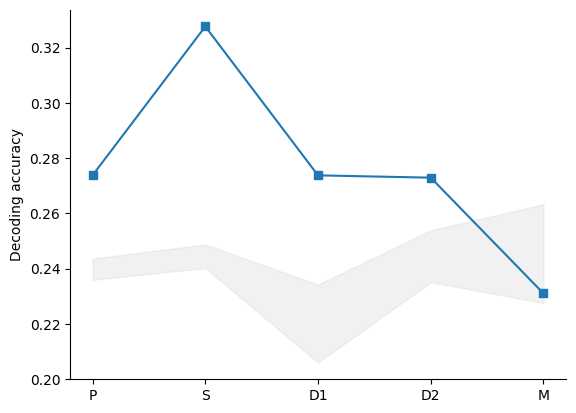

In [298]:
ax = plt.subplot(111)
plt.plot(range(5), np.mean(cv_scores, -1), "s-")
plt.fill_between(
    range(5),
    np.quantile(cv_scores_surr, 0.05, -1),
    np.quantile(cv_scores_surr, 0.95, -1),
    color="lightgray",
    alpha=0.3,
)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.ylabel("Decoding accuracy")
plt.xticks(range(5), ["P", "S", "D1", "D2", "M"]);

In [222]:
X = (
    out.groupby("roi")
    .mean("roi")
    .sel(freqs=slice(27, 35), times=slice(0, 0.5))
    .mean("times")
    .assign_coords({"trials": stim.astype(int)})
    .stack(z=("freqs", "trials"))
)

In [223]:
y = X.trials.data
X = X.data

In [226]:
x_train, x_test, y_train, y_test = train_test_split(
    X.T, y, test_size=0.33, shuffle=True
)

In [228]:
max_depths = np.arange(1, 21, 1, dtype=int)
n_estimators = [100, 200, 500, 1000]
max_features = ["sqrt", X.shape[0]]

parameters = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "ccp_alpha": [0, 0.001, 0.01, 0.1],
}

est = RandomForestClassifier(n_jobs=20, bootstrap=True)

clf = GridSearchCV(
    estimator=est,
    param_grid=parameters,
    cv=5,
    scoring="accuracy",
    n_jobs=10,
    return_train_score=True,
    verbose=60,
)

clf.fit(x_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=20), n_jobs=10,
             param_grid={'ccp_alpha': [0, 0.001, 0.01, 0.1],
                         'max_features': ['sqrt', 26],
                         'n_estimators': [100, 200, 500, 1000]},
             return_train_score=True, scoring='accuracy', verbose=60)

In [229]:
clf.best_params_

{'ccp_alpha': 0.001, 'max_features': 'sqrt', 'n_estimators': 500}

In [230]:
est = RandomForestClassifier(
    **clf.best_params_,
    n_jobs=-1,
)
# est.fit(x_train, y_train)

In [231]:
cv = cross_val_score(est, x_train, y_train, n_jobs=5, cv=7)

[CV 5/5; 1/32] START ccp_alpha=0, max_features=sqrt, n_estimators=100...........
[CV 5/5; 1/32] END ccp_alpha=0, max_features=sqrt, n_estimators=100;, score=(train=1.000, test=0.361) total time=   0.7s
[CV 4/5; 3/32] START ccp_alpha=0, max_features=sqrt, n_estimators=500...........
[CV 4/5; 3/32] END ccp_alpha=0, max_features=sqrt, n_estimators=500;, score=(train=1.000, test=0.365) total time=   3.5s
[CV 3/5; 5/32] START ccp_alpha=0, max_features=26, n_estimators=100.............
[CV 3/5; 5/32] END ccp_alpha=0, max_features=26, n_estimators=100;, score=(train=1.000, test=0.301) total time=   0.6s
[CV 2/5; 6/32] START ccp_alpha=0, max_features=26, n_estimators=200.............
[CV 2/5; 6/32] END ccp_alpha=0, max_features=26, n_estimators=200;, score=(train=1.000, test=0.321) total time=   1.3s
[CV 3/5; 7/32] START ccp_alpha=0, max_features=26, n_estimators=500.............
[CV 3/5; 7/32] END ccp_alpha=0, max_features=26, n_estimators=500;, score=(train=1.000, test=0.276) total time=   2

In [232]:
cv.mean()

0.3234165287736716

In [216]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [84]:
clf = make_pipeline(StandardScaler(), SVC(gamma="auto", kernel="rbf"))

In [85]:
clf.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [86]:
accuracy_score(y_test, clf.predict(x_test))

0.23711340206185566

In [88]:
clf.predict(x_test)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 5, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2,
       3, 3, 2, 3, 3, 3, 2, 3, 2, 3, 3, 2, 2, 3, 3, 2, 2, 2, 2, 3, 5, 2,
       2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 3, 3, 2, 3, 3, 2,
       2, 2, 2, 3, 5, 2, 5, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3,
       2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 5, 3, 2, 2, 2, 2, 3, 2, 2, 2, 3,
       2, 2, 2, 3, 2, 3, 2, 2, 4, 5, 3, 2, 3, 3, 3, 2, 3, 2, 3, 3, 2, 2,
       5, 2, 2, 3, 2, 3, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 3,
       3, 2, 2, 3, 2, 2, 2, 3, 2, 3, 2, 2, 2, 3, 2, 3, 2, 2, 3, 2, 2, 3,
       5, 2, 2, 2, 2, 5, 2, 2, 2, 2, 5, 2, 2, 2, 2, 3, 2, 3, 5, 3, 3, 2,
       2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, 2, 3, 2, 2, 3, 3,
       2, 2, 5, 2, 2, 2, 2, 3, 3, 2, 3, 2, 2, 2, 3, 3, 2, 2, 3, 2, 3, 2,
       2, 2, 2, 3, 2, 3, 5, 3, 2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 2, 3, 2, 2,
       2, 3, 2, 2, 5, 2, 2, 3, 2, 3, 2, 2, 2, 2, 5, 2, 2, 3, 3, 2, 3, 2,
       2, 2, 2, 2, 5])

In [87]:
y_test

array([1, 2, 5, 2, 3, 1, 4, 5, 5, 4, 2, 3, 1, 3, 4, 1, 1, 1, 4, 1, 2, 1,
       3, 2, 5, 3, 5, 4, 4, 1, 1, 1, 4, 1, 4, 5, 2, 1, 1, 1, 3, 5, 2, 5,
       5, 4, 3, 5, 3, 2, 2, 1, 5, 5, 2, 1, 1, 2, 1, 3, 5, 2, 4, 2, 5, 3,
       3, 3, 3, 1, 4, 2, 4, 3, 2, 3, 3, 1, 5, 4, 2, 2, 1, 3, 4, 2, 2, 1,
       2, 4, 3, 5, 5, 2, 3, 4, 1, 3, 5, 4, 3, 2, 5, 5, 1, 1, 1, 2, 1, 5,
       3, 3, 1, 5, 5, 4, 1, 5, 5, 5, 3, 4, 3, 1, 3, 5, 4, 1, 3, 3, 5, 2,
       5, 2, 1, 4, 5, 2, 5, 3, 5, 3, 1, 4, 5, 5, 2, 2, 3, 5, 2, 1, 2, 3,
       2, 2, 4, 2, 3, 1, 2, 1, 2, 5, 1, 4, 5, 5, 5, 5, 4, 3, 3, 4, 1, 2,
       4, 2, 5, 1, 1, 5, 1, 2, 1, 2, 4, 3, 4, 5, 2, 3, 2, 4, 1, 5, 3, 3,
       1, 4, 5, 1, 3, 2, 5, 4, 4, 3, 1, 5, 1, 2, 1, 5, 4, 4, 5, 4, 5, 3,
       1, 1, 3, 5, 3, 5, 5, 3, 5, 1, 5, 4, 2, 1, 1, 5, 2, 1, 2, 3, 4, 4,
       4, 1, 2, 1, 3, 3, 5, 1, 1, 1, 1, 5, 2, 5, 4, 3, 3, 5, 2, 2, 1, 2,
       1, 3, 4, 1, 4, 5, 2, 4, 5, 4, 3, 2, 5, 3, 2, 2, 3, 2, 3, 1, 3, 2,
       5, 3, 5, 2, 5])

In [22]:
import torch
from torch import nn

In [39]:
class autoencoder(nn.Module):
    def __init__(self):

        super().__init__()

        self.enc = nn.Sequential(
            nn.Linear(in_features=11025, out_features=1000),
            nn.ReLU(),
            nn.Linear(in_features=1000, out_features=300),
            nn.ReLU(),
            nn.Linear(in_features=300, out_features=200),
            nn.ReLU(),
        )

        self.dec = nn.Sequential(
            nn.Linear(in_features=200, out_features=300),
            nn.ReLU(),
            nn.Linear(in_features=300, out_features=1000),
            nn.ReLU(),
            nn.Linear(in_features=1000, out_features=11025),
            nn.Sigmoid(),
        )

    def forward(self, X):

        X = self.enc(X)
        X = self.dec(X)

        return X


class encoder(nn.Module):
    def __init__(self):

        super().__init__()

        self.enc = list(model.children())[0]

    def forward(self, X):

        return self.enc(X)


class decoder(nn.Module):
    def __init__(self):

        super().__init__()

        self.dec = list(model.children())[1]

    def forward(self, X):

        return self.dec(X)

In [40]:
device = "cuda"

In [41]:
model = autoencoder()
model.to(device)

autoencoder(
  (enc): Sequential(
    (0): Linear(in_features=11025, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=200, bias=True)
    (5): ReLU()
  )
  (dec): Sequential(
    (0): Linear(in_features=200, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=1000, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1000, out_features=11025, bias=True)
    (5): Sigmoid()
  )
)

In [42]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

In [43]:
X = tm.data.reshape(-1, 105 * 105)
y = tm.trials.data

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train, y_train = torch.Tensor(X_train), torch.Tensor(y_train)
X_test, y_test = torch.Tensor(X_test), torch.Tensor(y_test)

In [46]:
trainloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train, y_train),
    batch_size=32,
    shuffle=True,
)

testloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_test, y_test),
    batch_size=32,
    shuffle=True,
)

In [47]:
for epoch in range(1000):

    running_loss_train = 0.0
    running_loss_val = 0.0
    for inputs, _ in trainloader:
        model.train()
        inputs = inputs.to(device)

        model.zero_grad()

        outputs = model.forward(inputs)

        loss = criterion(outputs, inputs)

        loss.backward()
        optimizer.step()

        running_loss_train += loss.item()

    for inputs, _ in testloader:
        model.eval()
        inputs = inputs.to(device)

        outputs = model.forward(inputs)

        loss = criterion(outputs, inputs)

        running_loss_val += loss.item()

    print(
        f"Epoch {epoch + 1}: train loss = {running_loss_train / len(trainloader)}, test loss = {running_loss_val / len(testloader)}",
        end="\r",
    )

In [48]:
imagens_teste = next(iter(testloader))[0][:10].to(device)

In [49]:
enc = encoder()
enc.to(device)

encoder(
  (enc): Sequential(
    (0): Linear(in_features=11025, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=200, bias=True)
    (5): ReLU()
  )
)

In [50]:
dec = decoder()
dec.to(device)

decoder(
  (dec): Sequential(
    (0): Linear(in_features=200, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=1000, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1000, out_features=11025, bias=True)
    (5): Sigmoid()
  )
)

In [51]:
im_enc = enc(imagens_teste)

In [52]:
im_dec = dec(im_enc)

In [53]:
# Formatando as imagens para visualização
imagens_teste = imagens_teste.detach().cpu().numpy().reshape(-1, 105, 105)
imagens_codificadas = im_enc.detach().cpu().numpy().reshape(-1, 10, 10)
imagens_decodificadas = im_dec.detach().cpu().numpy().reshape(-1, 105, 105)

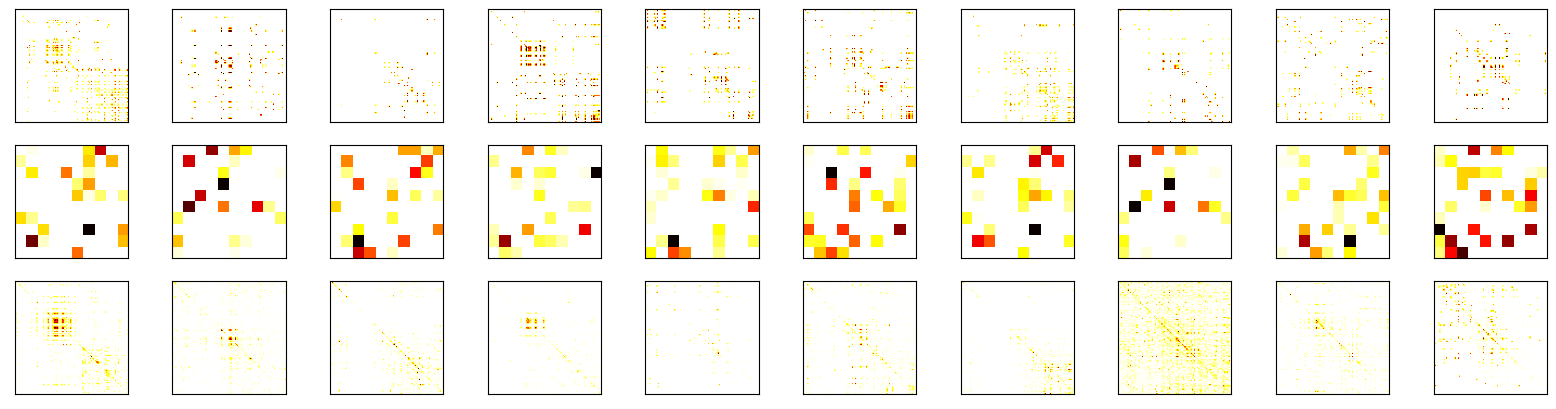

In [54]:
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(20, 5))
for imagens, ax_row in zip(
    [imagens_teste, imagens_codificadas, imagens_decodificadas], axes
):
    for img, ax in zip(imagens, ax_row):
        ax.imshow(img, cmap="hot_r")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [55]:
tm_enc = enc(torch.Tensor(X).to(device))

array([[0.        , 1.5220838 , 2.1680772 , ..., 0.        , 0.        ,
        2.3113935 ],
       [0.62913144, 1.3586916 , 1.070862  , ..., 0.        , 0.7203525 ,
        1.8942438 ],
       [0.        , 0.        , 0.5101045 , ..., 0.37647575, 0.6822968 ,
        0.        ],
       ...,
       [0.        , 0.32611582, 1.5473094 , ..., 0.        , 2.883621  ,
        0.        ],
       [1.5539798 , 0.        , 7.7274294 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.8647566 , 1.9392548 , ..., 2.400521  , 1.4739281 ,
        6.779308  ]], dtype=float32)